In [1]:
import scipy
from scipy.signal import periodogram
import pandas as pd
import numpy as np
from scipy.integrate import simps
from numpy import trapz
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def add_jerk(df):                     #function for adding the jerk column in the data
  acc1 = df['accel_meters_ps']
  acc2 = df['accel_meters_ps'].shift(periods=1, fill_value=0)
  df['jerk'] = acc1 - acc2            #readings are spaced 1 sec apart so we have taken the difference directly 
  return df

In [4]:
def delete_idle_period(df):     #to delete the zero velocity periods by making the time stamps continuos (natural numbers)
  t = df['cycle_sec']
  for i in range(len(t)):
    df['cycle_sec'][i]=i
  return df

In [5]:
def scale(speed):             #scale speed by subtracting mean speed
  avg_speed = np.average(speed)
  speed_scaled = speed-avg_speed
  return speed_scaled

In [6]:
def cutoff_freq(x,y):         # x = frequency  y = speed periodogram
  r = trapz(y,x) * 0.99
  i = 1
  eps = 1
  auc = 0
  while r > auc:              #iteratively find the point at which 99% of the area under the curve is occpuied
    auc = auc + (x[i]-x[i-1])*min(y[i],y[i-1]) + 0.5*(x[i]-x[i-1])*abs(y[i]-y[i-1])
    i = i+1
    if auc==r:
      return i
  return i-1

In [7]:
def driver_score(x,y1,c):     # x = frequency y1= jerk periodogram c=cutoff frequency
  lfj = trapz(y1[:c],x[:c])      
  totalj = trapz(y1,x)
  mean_pdj = np.mean(y1)
  DA = (((totalj-lfj)/totalj)*mean_pdj) 
  return DA

In [8]:
def get_score(df):
  df = delete_idle_period(df)
  df = add_jerk(df)
  scaled = scale(df['speed_mph'])
  f, Pxx_den = periodogram(scaled)
  cf = cutoff_freq(f, Pxx_den)
  f1, Pxx_den1 = periodogram(df['jerk'])
  return driver_score(f1, Pxx_den1, cf)

In [9]:
import os

all_trips = []
directory = '/content/drive/MyDrive/EC5_EE338' 
for filename in os.listdir(directory): 
  df = pd.read_csv('/content/drive/MyDrive/EC5_EE338/' + filename)
  all_trips.append(df)  

len(all_trips)

100

In [10]:
score = []
power = []
for trip in all_trips: 
  avg_power = np.mean(trip['TotalPowerPositive_W'])/np.mean(trip['kmTravelled'])
  coeff = get_score(trip) 
  power.append(avg_power)
  score.append(coeff)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


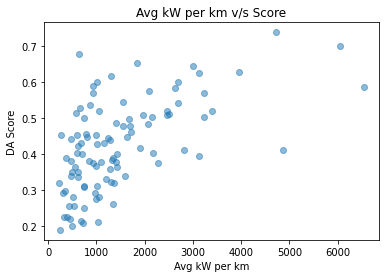

In [11]:
plt.scatter(power, score, alpha=0.5)  #we should observe a positive correlation between mean power per km and driver score
plt.title('Avg kW per km v/s Score')
plt.xlabel('Avg kW per km')
plt.ylabel('DA Score')
#plt.xlim((0,500))
#plt.ylim((0,500))
plt.show()

Clustering the drive cycles by duration and mean speed

In [12]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [13]:
clust = []
for trip in all_trips:
  clust.append((len(trip),np.mean(trip['speed_SI'])))

In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clust)

In [15]:
kmeans = KMeans(
    init="random",
    n_clusters=6,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [16]:
kmeans.fit(scaled_features)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=6,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [17]:
kmeans.inertia_

33.92963624640187

In [18]:
labl = kmeans.labels_
labl

array([4, 5, 3, 5, 4, 0, 4, 5, 4, 0, 3, 1, 4, 2, 2, 3, 2, 1, 3, 3, 3, 4,
       5, 5, 5, 5, 5, 2, 2, 0, 4, 4, 4, 0, 0, 5, 1, 3, 1, 4, 4, 4, 2, 1,
       5, 2, 3, 4, 4, 3, 5, 3, 1, 4, 5, 2, 4, 4, 2, 4, 1, 1, 5, 2, 4, 1,
       2, 5, 4, 1, 1, 5, 4, 4, 3, 4, 4, 5, 1, 4, 5, 5, 1, 5, 4, 2, 0, 0,
       5, 2, 5, 2, 5, 4, 5, 5, 3, 4, 0, 5], dtype=int32)

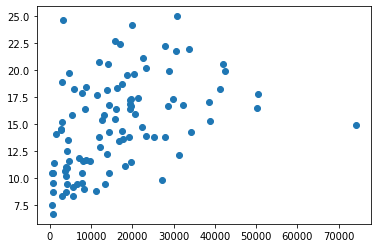

In [19]:
plt.scatter(*zip(*clust))
plt.show()

In [20]:
avg_speed = []
duration = []
for trip in all_trips:
  duration.append(len(trip))
  avg_speed.append(np.mean(trip['speed_SI']))

pltdf = pd.DataFrame(dict(duration=np.array(duration), speed = np.array(avg_speed), labels = labl))

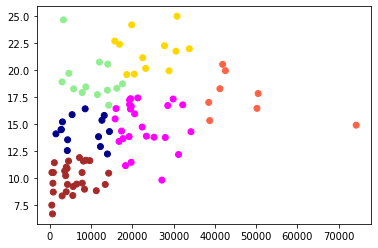

In [21]:
fig, ax = plt.subplots()
colors = {0:'tomato', 1:'lightgreen', 2:'darkblue', 3:'gold', 4:'brown', 5: 'fuchsia'}
ax.scatter(pltdf['duration'],pltdf['speed'], c=pltdf['labels'].map(colors))
plt.show()

Clustered cycles - 6 types of road conditions (duration is included for completeness of information, it does not decide the recommendation level)

Low average speed indicates congested roads - So for a driver with a high aggressiveness score belonging to orange or green cluster will be given light recommendations; pink, blue or brown will be given medium strength recommendations and yellow will be given strong recommendations.